In [39]:
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from constants.plot_settings import cmap_colors as rgc_colors

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

from scipy.stats import pearsonr as lincorr

from functools import partial

import sys
sys.path.append('/gpfs01/euler/User/lhoefling/GitHub/nnfabrik_euler')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


wandb.login()
run = wandb.init(
    project="hoefling_2022_reproduction",
    notes="Testing new sampler bounds without clip reordering.",
    tags=None,
    job_type=None,
    name=None,
)

wandb.config.update({**model_config, **trainer_config})

# functions

In [40]:
class IdentityReducer:
    def __init__(self):
        pass
    def __call__(self, activation):
        return activation

def get_responses_(model, stimulus, max_stim_per_batch, reduce_fn):
    n_stim = stimulus.shape[0]
    if n_stim > max_stim_per_batch:
        all_responses = []
        for batch in image_batches(max_stim_per_batch, stimulus, n_stim):
            a = model(batch)
            b = reduce_fn(batch)
            print(a.shape, b.shape)
            responses = reduce_fn(model(batch)).detach().cpu().numpy()
            all_responses.append(responses)
        all_responses = np.vstack(all_responses)
    else:
        all_responses = reduce_fn(model(stimulus)).detach().cpu().numpy()
    return all_responses


def image_batches(batch_size, stimulus, num_stims):
    """
    Generator function dividing the resulting images from all parameter combinations into batches.

    Args:
        batch_size (int): The number of images per batch.

    Yields: The image batches as numpy.ndarray with shape (batch_size, image height, image width) or
            (num_params % batch_size, image height, image width), for the last batch.
    """
    for batch_start in np.arange(0, num_stims, batch_size):
        batch_end = np.minimum(batch_start + batch_size, num_stims)
        images = [stimulus[i] for i in range(batch_start, batch_end)]
        yield torch.stack(images)


def get_model_responses(model, stimulus, dataset_hash, ensemble_hash, session_id,
                            batch_size=1000, reduce_fn=None):
    """ For a given model, stimulus and restriction (dataset & ensemble), return a
    dictionary of neuron_ids to responses to the stimulus"""
    if reduce_fn is None:
        reduce_fn = IdentityReducer()
    
    responses = get_responses_(partial(model, data_key=session_id), stimulus,
                               batch_size, reduce_fn)
    return responses



In [41]:
def nested_dict_to_dataframe(nested_dict):
    """
    Convert a nested dictionary with numpy arrays to a pandas DataFrame,
    adding dataset_hashes and session_ids as columns.

    Parameters:
    nested_dict (dict): The nested dictionary with numpy arrays to convert.

    Returns:
    pd.DataFrame: The resulting DataFrame.
    """
    # Create a list of records
    records = []

    for dataset_hash, sessions in nested_dict.items():
        for session_id, session_data in sessions.items():
            if session_id == 'session_1_ventral2_20200701':
                continue
            # Extract all keys from session data
            keys = list(session_data.keys())
            keys.remove('roi_coords')
            # Extract the number of cells from the first numpy array (assuming all arrays have the same length)
            n_cells = session_data[keys[0]].shape[0]
            # Create individual records for each cell in all arrays
            for i in range(n_cells):
                #if i == 1:
                    #print(session_data['date'])
                    #print(session_data['exp_num'])
                    #print(session_data['field_id'])
                record = {'dataset_hash': dataset_hash, 
                          'session_id': session_id,
                          'neuron_id': '_'.join([''.join(session_data['date'].split('-')), # date
                                                 str(session_data['exp_num']),
                                                 str(session_data['field_id']),
                                                 str(session_data['roi_ids'][i]),
                                                 's_5'
                                                ])
                         }
                for key in keys:
                    value = session_data[key]
                    # If value is not a numpy array, tile it to match the number of cells
                    if not isinstance(value, np.ndarray):
                        value = np.tile(value, (n_cells, 1))
                    #print(key)
                    #print(value)
                    record[key] = value[i].squeeze()
            
                #record['movie_qi'] = movie_qis_by_hash[dataset_hash][session_id][i]
                #record['test_corr'] = corrs_by_hash[dataset_hash][session_id][i].mean()
                #record['test_corr_to_avg'] = corrs_to_avg_by_hash[dataset_hash][session_id][i]
                records.append(record)

    # Create the DataFrame from the list of records
    df = pd.DataFrame(records)
    df.set_index('neuron_id', drop=False, inplace=True)
    return df





# calculate eval metrics

In [42]:

#def get_resp_idxs(movie_data_dicts, dataset_hash, session_id):
#    '''
#    For all ROIs in given session, return the index into the response array 
#    for those ROIs. The index differs from the roi_id for two reasons:
#    1. roi_ids are 1-indexed
#    2. some ROIs are removed from the response array during quality filtering
#    '''
#    roi_ids = movie_data_dicts[dataset_hash][session_id]['roi_ids']
#    resp_idxs = np.array([list(roi_ids).index(roi_id) for roi_id in roi_ids])
#    return resp_idxs
#
#
#def get_model_readout_idxs(movie_data_dicts, dataset_hash, session_id, resp_idxs):
#    '''
#    For all ROIs in a given session, return the index into the model readout array
#    for those ROIs. They are returned in the same order as the resp_idxs.
#    '''
#    model_readout_idxs = np.array(
#        [movie_data_dicts[dataset_hash][session_id]['model_readout_idx'][resp_idx] for resp_idx in resp_idxs]
#         )
#    return model_readout_idxs

    
def _calculate_correlations(responses, predictions, resp_idxs, model_readout_idxs):
    """
    Takes as input the test responses (3 reps) and the model predictions, 
    and calculates the avg. correlation, and the correlation to avg.
    Correlation measure is linear correlation (Pearson)

    Inputs:
    ------
    responses:   torch.Tensor    shape n_neurons x n_reps x n_timesteps
    predictions: np.Array        shape n_timesteps-30 x n_neurons
    """
    n_neurons = responses.shape[0]
    corrs = np.zeros((n_neurons, 3))
    corrs_to_avg = np.zeros(n_neurons)
    responses = np.transpose(responses, (2, 0, 1)) # to shape n_timesteps x n_neurons x n_reps
    for neuron in range(n_neurons):
        for rep in range(3):
            corrs[neuron, rep] = lincorr(responses[30:, resp_idxs[neuron], rep], predictions[:, model_readout_idxs[neuron]]).statistic
        corrs_to_avg[neuron] = lincorr(responses[30:, resp_idxs[neuron]].mean(axis=-1), predictions[:, model_readout_idxs[neuron]]).statistic
    return corrs, corrs_to_avg


#def calculate_correlations(movie_data_dicts, dataloaders_dict, dataset_hash, session_id, predictions):
#    resp_idxs = get_resp_idxs(movie_data_dicts, dataset_hash, session_id)
#    model_readout_idxs = get_model_readout_idxs(movie_data_dicts, dataset_hash, session_id, resp_idxs)
#    corrs, corrs_to_avg = _calculate_correlations(
#        dataloaders_dict[dataset_hash]['test'][session_id].dataset.test_responses_by_trial,
#        predictions,
#        resp_idxs,
#        model_readout_idxs
#    )
#    movie_qis = calculate_nat_reliability_index(
#        movie_data_dicts[dataset_hash][session_id]['natural_detrended_snippets'],
#    )
#    return corrs, corrs_to_avg, movie_qis


#def calculate_nat_reliability_index(responses):
#    """
#    Takes as input the test responses (3 reps) 
#
#    Inputs:
#    ------
#    responses:   np.ndarray      shape n_neurons x n_timesteps x n_moviesnippets
#    """
#    n_neurons = responses.shape[0]
#    slices = np.asarray([
#                responses[..., 0:5].reshape(n_neurons, -1, order='F'),
#                responses[..., 59:64].reshape(n_neurons, -1, order='F'),
#                responses[..., 118:].reshape(n_neurons, -1, order='F'),
#            ])
#    print(slices.shape)
#    movie_qis = np.zeros(n_neurons)
#    numerator = np.var(
#        np.mean(   # average across repetitions
#            slices, 
#            axis=0
#        ), axis=-1  # variance of avg. response across time
#    )
#    denom = np.mean(
#        np.var(    # variance across time
#            slices,  
#            axis=-1
#        ), axis=0  # variance across time avg. across reps
#    )
#    movie_qis = numerator / denom
#    return movie_qis, slices


def calculate_nat_reliability_index(df_row):
    scan_frequency = 7.81
    traces, traces_times, triggertimes = df_row[['natural_detrended_traces', 
                                             'natural_traces_times',
                                             'natural_trigger_times']]
    test_triggers = [triggertimes[0], triggertimes[59], triggertimes[118]] #this assumes a specific presentation order! valid for mouse cam
    idxs = [np.nonzero(np.isclose(traces_times, np.ones_like(traces_times) * s, atol=1e-01))[0][0]
           for s in test_triggers]
    test_traces = np.asarray(
        [traces[i:i + int(np.ceil(scan_frequency * 25))] for i in idxs]
    )
    test_traces = np.transpose(test_traces)
    numerator = np.var(np.mean(test_traces, axis=-1), axis=0)
    denom = np.mean(np.var(test_traces, axis=0), axis=-1)
    movie_qi = numerator / denom
    return movie_qi   

#def calculate_nat_reliability_index(dataframe, neuron_id):
#    scan_frequency = 7.81
#    traces, traces_times, triggertimes = dataframe[['natural_detrended_traces', 
#                                             'natural_traces_times',
#                                             'natural_trigger_times']].loc[neuron_id]
#    test_triggers = [triggertimes[0], triggertimes[59], triggertimes[118]] #this assumes a specific presentation order! valid for mouse cam
#    idxs = [np.nonzero(np.isclose(traces_times, np.ones_like(traces_times) * s, atol=1e-01))[0][0]
#           for s in test_triggers]
#    test_traces = np.asarray(
#        [traces[i:i + int(np.ceil(scan_frequency * 25))] for i in idxs]
#    )
#    test_traces = np.transpose(test_traces)
#    print(test_traces.shape)
#    numerator = np.var(np.mean(test_traces, axis=-1), axis=0)
#    denom = np.mean(np.var(test_traces, axis=0), axis=-1)
#    movie_qi = numerator / denom
#    return movie_qi    

# Define constants

## hashes and paths

In [43]:
dh2eh_linear = {'069836032a542cb20fe4c678dde07615': '16656282b787d3c02156306fafeb412f',
 '3fa1f6b6c48d3512911ec865c5314069': 'd470e5c944f6b8ebe83a887b30d560ca',
 '4fdcebca20eccfb13a45e6db91594047': '6f8e5b238af4c313157c4078c2f6cb06',
 '57ff42f31240ab511be30f98b4a07ffe': '0593c87c0db906732b7b10c5e6c1d3ca',
 'b0eac5ecc79e497f4d9c02d0990219c4': 'a4e4a35fb6cd6239ce3a9ef852fc0633',
 '5e620609fc7b491aa5edb4a5d4cd7276': 'c97149b334a802faf90e3c585d90a0f8',
        }

dh2eh = {'069836032a542cb20fe4c678dde07615': '910123855237157eeb15a488cf954368',
 '3fa1f6b6c48d3512911ec865c5314069': '166d959f04c2a75f8a96e5a7050b76a2',
 '4fdcebca20eccfb13a45e6db91594047': '75798bfbbb1d93855e3ce894251caa0f',
 '57ff42f31240ab511be30f98b4a07ffe': '9d574ab9fcb85e8251639080c8d402b7',
 'b0eac5ecc79e497f4d9c02d0990219c4': '7c3dc62c6321e2eb4699c18423a9e21f',
 '5e620609fc7b491aa5edb4a5d4cd7276': 'db311144177133200d3b805fadd20c70',
        }

dataset_hashes = list(dh2eh.keys())
ensemble_hashes = list(dh2eh.values())

file_name_template = r'2024-06-15_neuron_data_stim_c285329_responses_{}_wri.h5'
data_file_names = [file_name_template.format(dh[:7]) for dh in dataset_hashes]

data_file_names.pop()
data_file_names.append('2024-06-15_neuron_data_stim_41fc277_responses_5e62060_wri.h5')

model_type = 'nonlinear'

base_folder = '/gpfs01/euler/User/lhoefling/project_clean_up/'

movie_file_name = '2024-01-11_movies_dict_c285329.pkl'
flipped_movie_file_name = '2024-05-27_movies_dict_41fc277.pkl'

## example NIDs

In [44]:
example_nids = {1: "20201117_2_2_66_s_5",
                5: "20201117_2_2_72_s_5",
                10: "20201117_2_2_96_s_5",
                18: "20201117_2_2_101_s_5",
                20: "20201117_2_2_46_s_5",
                21: "20201117_2_2_103_s_5", 
                23:  "20201117_2_2_80_s_5",
                24: "20201117_2_2_55_s_5",
                28:  "20201117_2_2_134_s_5", 
                31:  "20201117_2_2_115_s_5", 
                32:  "20201117_2_2_61_s_5", }

## plot settings

In [45]:
rc_dict = {'figure.dpi': 300,
                     'figure.figsize': [2,2],
                     'figure.frameon': False,
                     'font.size': 8,
                     'lines.markersize':1,
                       'lines.markeredgewidth': .1,
                     'legend.columnspacing': .5,
                     'legend.frameon': False,
                     'legend.markerscale': .4,
                     'legend.labelspacing': 0.1,
                     'legend.handletextpad': 0,
                     'legend.loc': "lower right",
           'axes.labelpad': 1.0,
            'xtick.major.pad': 1, 'ytick.major.pad': 1,
                
                     }

# Loading

### movies

In [46]:
# load the movie 
movies_dict = pickle.load(open('/'.join([base_folder, 'data', movie_file_name]), "rb"))

# load the movie file with the pre-flip-correction movie
movies_dict_flip = pickle.load(open('/'.join([base_folder, 'data', flipped_movie_file_name]), "rb"))

### load all datasets

In [47]:
movie_data_dicts = {}
dataloaders_dict = {}
for dh, dfn in zip(dataset_hashes, data_file_names):
    data_path = os.path.join(base_folder, "data", dfn)
    responses = load_h5_into_dict(data_path)
    _movie_data_dict = make_final_responses(responses, response_type="natural") # upsampling
    if dh == '5e620609fc7b491aa5edb4a5d4cd7276':
        _dataloaders = natmov_dataloaders_v2(
        _movie_data_dict, movies_dict_flip, seed=1000
    )
    else:
        _dataloaders = natmov_dataloaders_v2(
            _movie_data_dict, movies_dict, seed=1000
        )
    movie_data_dicts.update({dh:_movie_data_dict})
    dataloaders_dict.update({dh:_dataloaders})

Loading HDF5 file contents:   0%|          | 0/385 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/11 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/11 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/175 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/5 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/5 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/140 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/4 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/4 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/700 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/20 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/20 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/210 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/6 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/6 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/945 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/27 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/27 [00:00<?, ?it/s]

left
right


In [48]:
# ToDo 
dh_2_session_ids = {k: list(v.keys()) for k, v in movie_data_dicts.items()}
session_ids_2_dhs = {_v: k for k, v in movie_data_dicts.items() for _v in list(v.keys())}
# remove empty session
session_ids_2_dhs.pop('session_1_ventral2_20200701')
dh_2_session_ids['5e620609fc7b491aa5edb4a5d4cd7276'].remove('session_1_ventral2_20200701')

dh_2_session_ids_renamed = {dh: ['_'.join(el.split('_')[1:]) for el in v] for dh, v in dh_2_session_ids.items()}

# Collect data in dataframe

In [49]:
df = nested_dict_to_dataframe(movie_data_dicts)

# Predict test responses

### load model

In [50]:
def get_test_stim(dataloaders_dict, dataset_hash, session_id):
    return torch.unsqueeze(
        dataloaders_dict[dataset_hash]['test'][session_id].dataset.movies, 0
    ).cuda()


## CNN type model

In [51]:
prediction_dict = {}
corrs_dict = {}
corrs_to_avg_dict = {}
for dataset_hash in dataset_hashes:
    ensemble_hash = dh2eh[dataset_hash]
    model_path = os.path.join(base_folder, "models", 
                              model_type, ensemble_hash)
    data_info, ensemble_model = load_ensemble_retina_model_from_directory(model_path);
    for session_id in dh_2_session_ids[dataset_hash]:
        # get model predictions for test stimulus
        test_movie_stim = get_test_stim(dataloaders_dict, dataset_hash, session_id)
        predictions = get_model_responses(
        ensemble_model, 
        test_movie_stim, 
        dataset_hash, 
        ensemble_hash, 
        '_'.join(session_id.split('_')[1:])
       ).squeeze()

        current_neuron_ids = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['neuron_id'].values
        model_readout_idxs = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['model_readout_idx'].values
        [prediction_dict.update({_neuron_id:predictions[:, _model_readout_idx]})
         for _neuron_id, _model_readout_idx in zip(current_neuron_ids, model_readout_idxs)]

        # calculate correlation as metric of performance

        responses = dataloaders_dict[dataset_hash]['test'][session_id].dataset.test_responses_by_trial.numpy()
        corrs, corrs_to_avg = _calculate_correlations(responses, predictions, 
                                                      resp_idxs=np.arange(len(current_neuron_ids)),
                                                      model_readout_idxs=model_readout_idxs
                                                     )

        corrs_dict.update(dict(zip(current_neuron_ids, corrs)))
        corrs_to_avg_dict.update(dict(zip(current_neuron_ids, corrs_to_avg)))
    del data_info
    del ensemble_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Run garbage collection
    gc.collect()


Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Rando

In [52]:
df.insert(df.shape[1], 'corr_to_avg_recalc', 
          [corrs_to_avg_dict[neuron_id] for neuron_id in df.index])

df.insert(df.shape[1], 'single_trial_corr_recalc', 
          [corrs_dict[neuron_id].mean() for neuron_id in df.index])

df.insert(df.shape[1], 'test_prediction_recalc', [prediction_dict[neuron_id] for neuron_id in df.index])

## LN type model

In [53]:
prediction_dict = {}
corrs_dict = {}
corrs_to_avg_dict = {}
model_type = 'linear'
for dataset_hash in dataset_hashes:
    ensemble_hash = dh2eh_linear[dataset_hash]
    model_path = os.path.join(base_folder, "models", 
                              model_type, ensemble_hash)
    data_info, ensemble_model = load_ensemble_retina_model_from_directory(model_path);
    for session_id in dh_2_session_ids[dataset_hash]:
        # get model predictions for test stimulus
        test_movie_stim = get_test_stim(dataloaders_dict, dataset_hash, session_id)
        predictions = get_model_responses(
        ensemble_model, 
        test_movie_stim, 
        dataset_hash, 
        ensemble_hash, 
        '_'.join(session_id.split('_')[1:])
       ).squeeze()

        current_neuron_ids = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['neuron_id'].values
        model_readout_idxs = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['model_readout_idx'].values
        [prediction_dict.update({_neuron_id:predictions[:, _model_readout_idx]})
         for _neuron_id, _model_readout_idx in zip(current_neuron_ids, model_readout_idxs)]

        # calculate correlation as metric of performance

        responses = dataloaders_dict[dataset_hash]['test'][session_id].dataset.test_responses_by_trial.numpy()
        corrs, corrs_to_avg = _calculate_correlations(responses, predictions, 
                                                      resp_idxs=np.arange(len(current_neuron_ids)),
                                                      model_readout_idxs=model_readout_idxs
                                                     )

        corrs_dict.update(dict(zip(current_neuron_ids, corrs)))
        corrs_to_avg_dict.update(dict(zip(current_neuron_ids, corrs_to_avg)))
    del data_info
    del ensemble_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Run garbage collection
    gc.collect()


Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Rando

In [54]:
df.insert(df.shape[1], 'lin_corr_to_avg_recalc', 
          [corrs_to_avg_dict[neuron_id] for neuron_id in df.index])

df.insert(df.shape[1], 'lin_single_trial_corr_recalc', 
          [corrs_dict[neuron_id].mean() for neuron_id in df.index])

df.insert(df.shape[1], 'lin_test_prediction_recalc', [prediction_dict[neuron_id] for neuron_id in df.index])

# Insert additional columns to DF

In [55]:
df['movie_qis_recalc'] = df.apply(lambda x: calculate_nat_reliability_index(x), axis=1)

In [56]:
df['max_conf'] = df.apply(lambda row: row['group_confidences'][row['group_assignment']-1], axis=1)

# filter DF

In [57]:
restr_df = df[(df['max_conf']>=.25) & (df['group_assignment']<33)]

In [58]:
restr_df['single_trial_corr_recalc']

neuron_id
20210929_1_1_1_s_5      0.545532
20210929_1_1_2_s_5      0.567438
20210929_1_1_4_s_5      0.175013
20210929_1_1_5_s_5      0.174129
20210929_1_1_10_s_5     0.442377
                          ...   
20200303_2_5_113_s_5    0.382617
20200303_2_5_114_s_5    0.166397
20200303_2_5_117_s_5    0.279888
20200303_2_5_118_s_5    0.023719
20200303_2_5_119_s_5    0.224590
Name: single_trial_corr_recalc, Length: 3527, dtype: float64

# plot predictions for example cells

## define hashes for example session

In [59]:
dataset_hash_current = '57ff42f31240ab511be30f98b4a07ffe'

ensemble_hash_current = dh2eh[dataset_hash_current]
print(ensemble_hash_current)

session_id_current = '2_ventral2_20201117'
neuron_id_current = '20201117_2_2_66_s_5'
print(session_id_current)

9d574ab9fcb85e8251639080c8d402b7
2_ventral2_20201117


Text(0.5, 1.02, 'Test movie responses\n and predictions')

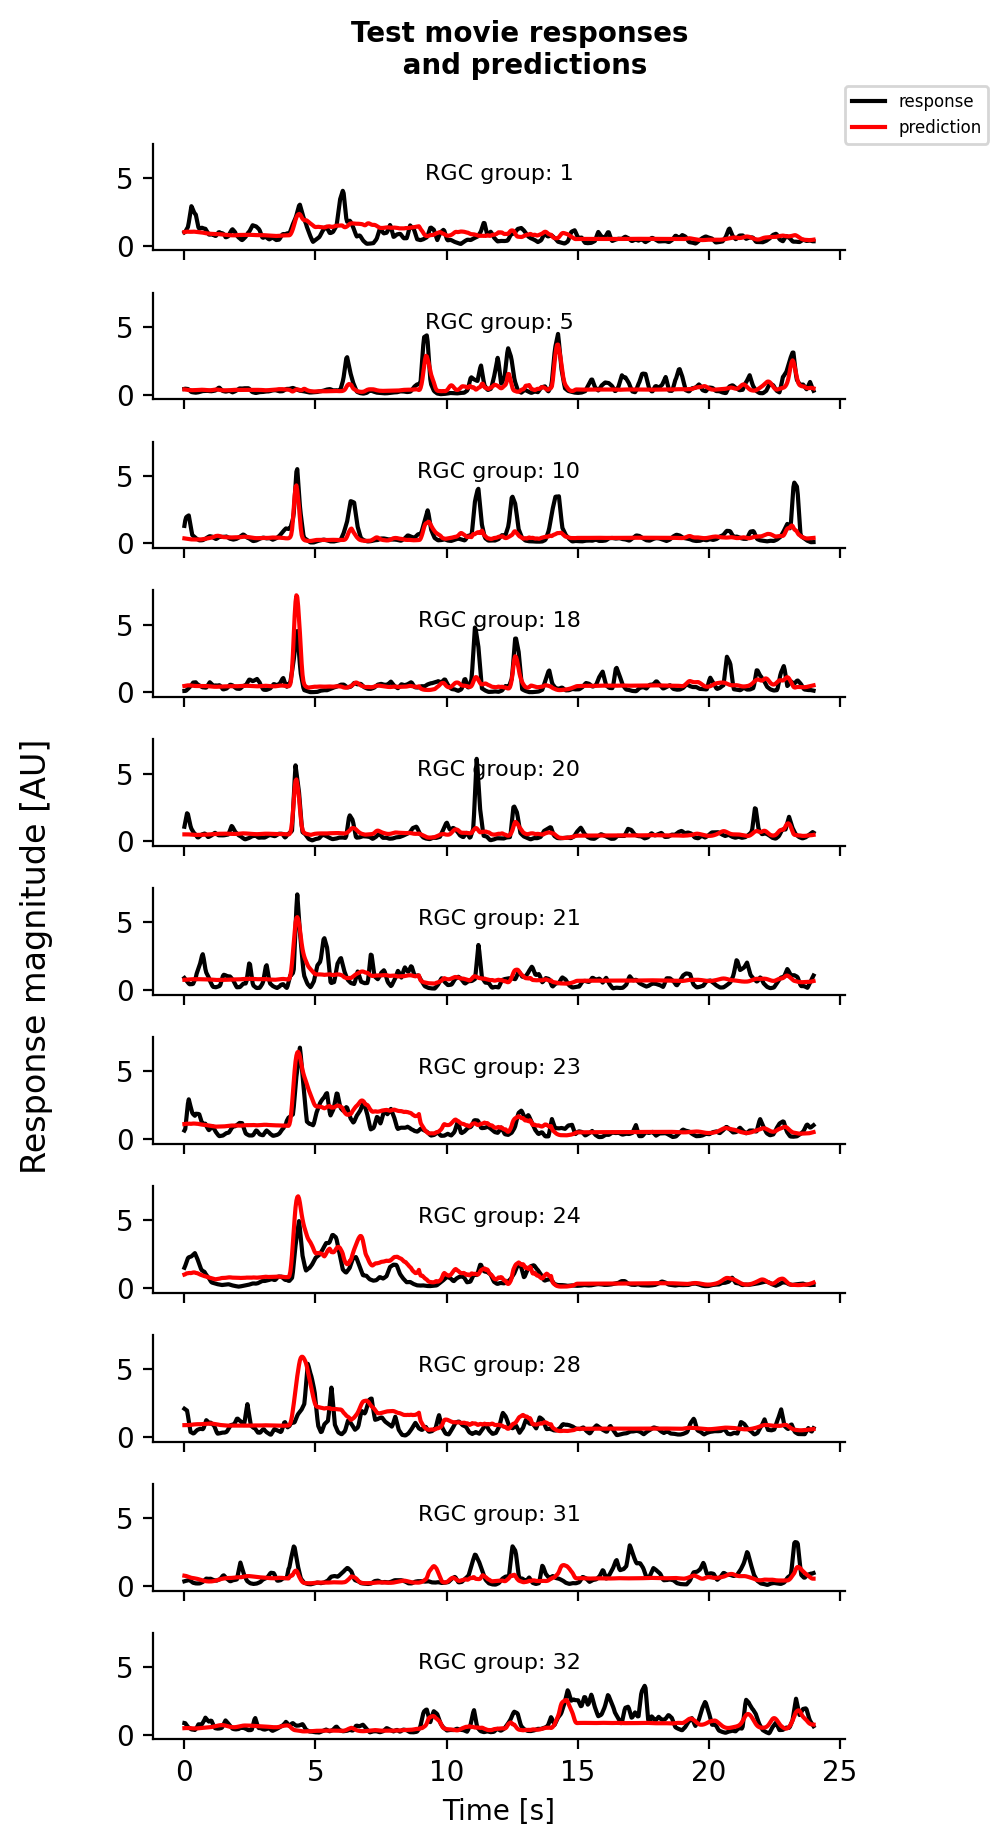

In [60]:
dataloaders_dict[dataset_hash_current]['test'][f'session_{session_id_current}'].dataset.responses
max_t = 720/30
time_axis = np.linspace(0, max_t, 720)
fig, axes = plt.subplots(len(example_nids), 1, figsize=(5, 9), sharex=True, sharey=True)
for i, (ax, (celltype, neuron_id)) in enumerate(zip(axes.ravel(), example_nids.items())):
    ax.plot(time_axis, df['test_response'].loc[neuron_id].mean(axis=0), color='k', label='response')
    ax.plot(time_axis, df['test_prediction_recalc'].loc[neuron_id], color='r', label='prediction')
    ax.set_title(f'RGC group: {celltype}', fontsize=8, y=.5)

axes[0].legend(fontsize=6, loc=(1,1))
ax.set_xlabel('Time [s]')
fig.supylabel('Response magnitude [AU]', x=0)
sns.despine()
plt.tight_layout()
plt.suptitle('Test movie responses\n and predictions', y=1.02, fontsize=10, fontweight='bold')

# plot corrs

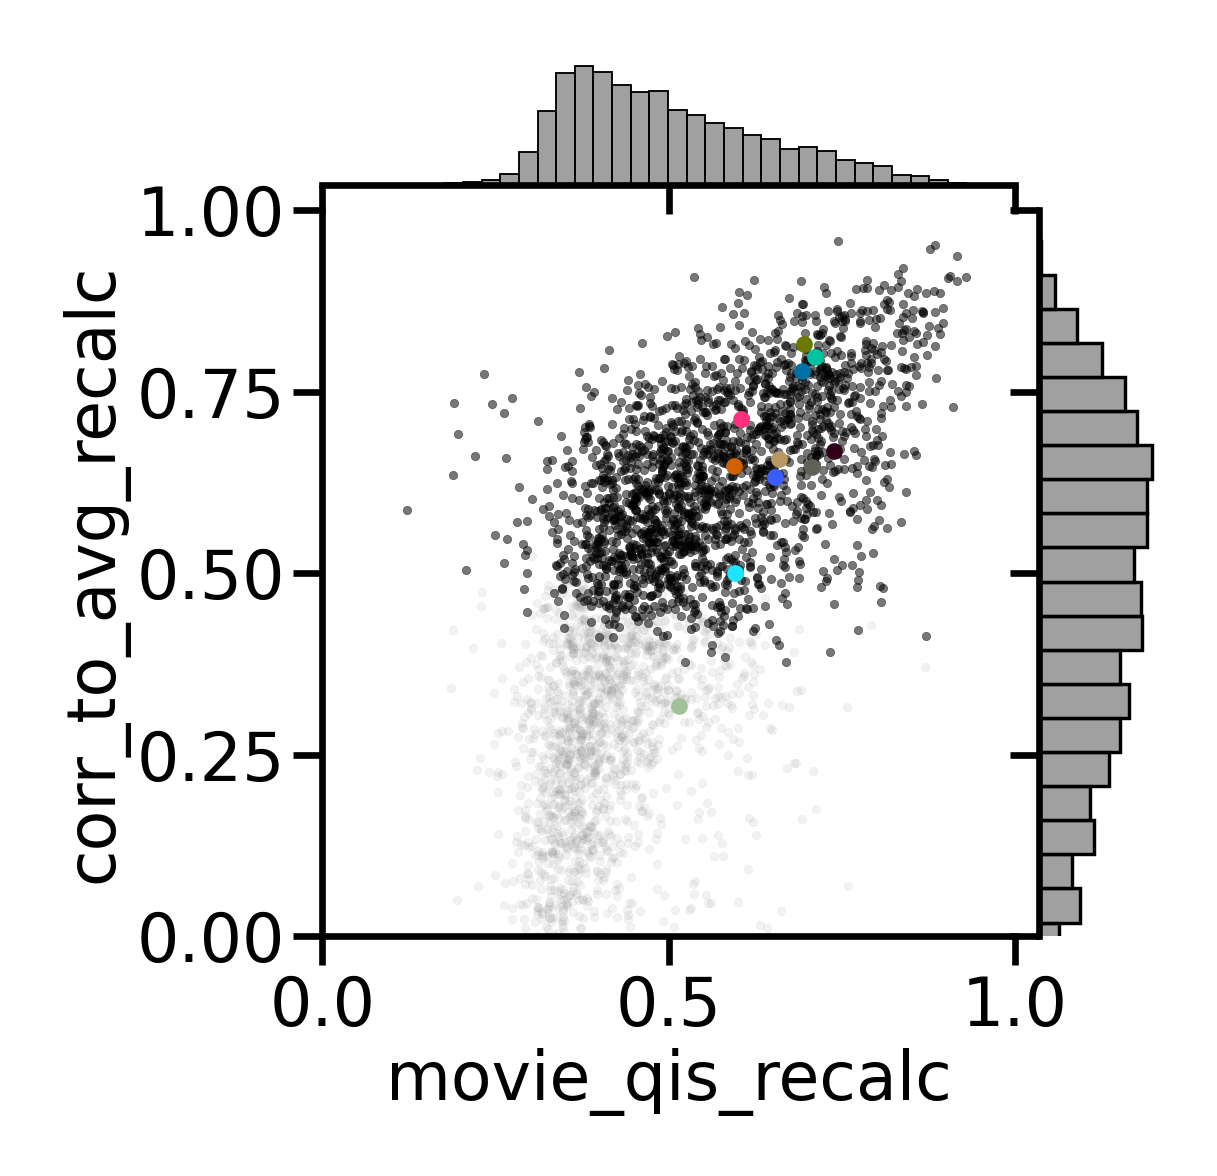

In [61]:
with mpl.rc_context(rc_dict):
    g = sns.jointplot(data=restr_df, x="movie_qis_recalc", y="corr_to_avg_recalc",
                    color="grey", edgecolor=None,
                      height=rc_dict["figure.figsize"][0],
                       alpha=.1, xlim=[0., 1], ylim=[0, 1]
                     )
    sns.scatterplot(data=restr_df[restr_df["single_trial_corr_recalc"]>.3], x="movie_qis_recalc", y="corr_to_avg_recalc",
                   color="k",edgecolor=None,
                      alpha=.5, ax=g.ax_joint
                    )
    for t, nid in example_nids.items():
        g.ax_joint.scatter(restr_df["movie_qis_recalc"].loc[nid], 
                           restr_df["corr_to_avg_recalc"].loc[nid],
                           color=rgc_colors[t-1],
                           
                           
                           )

In [62]:
temp_df = restr_df[restr_df['group_assignment']==t]
temp_df.shape

(446, 54)

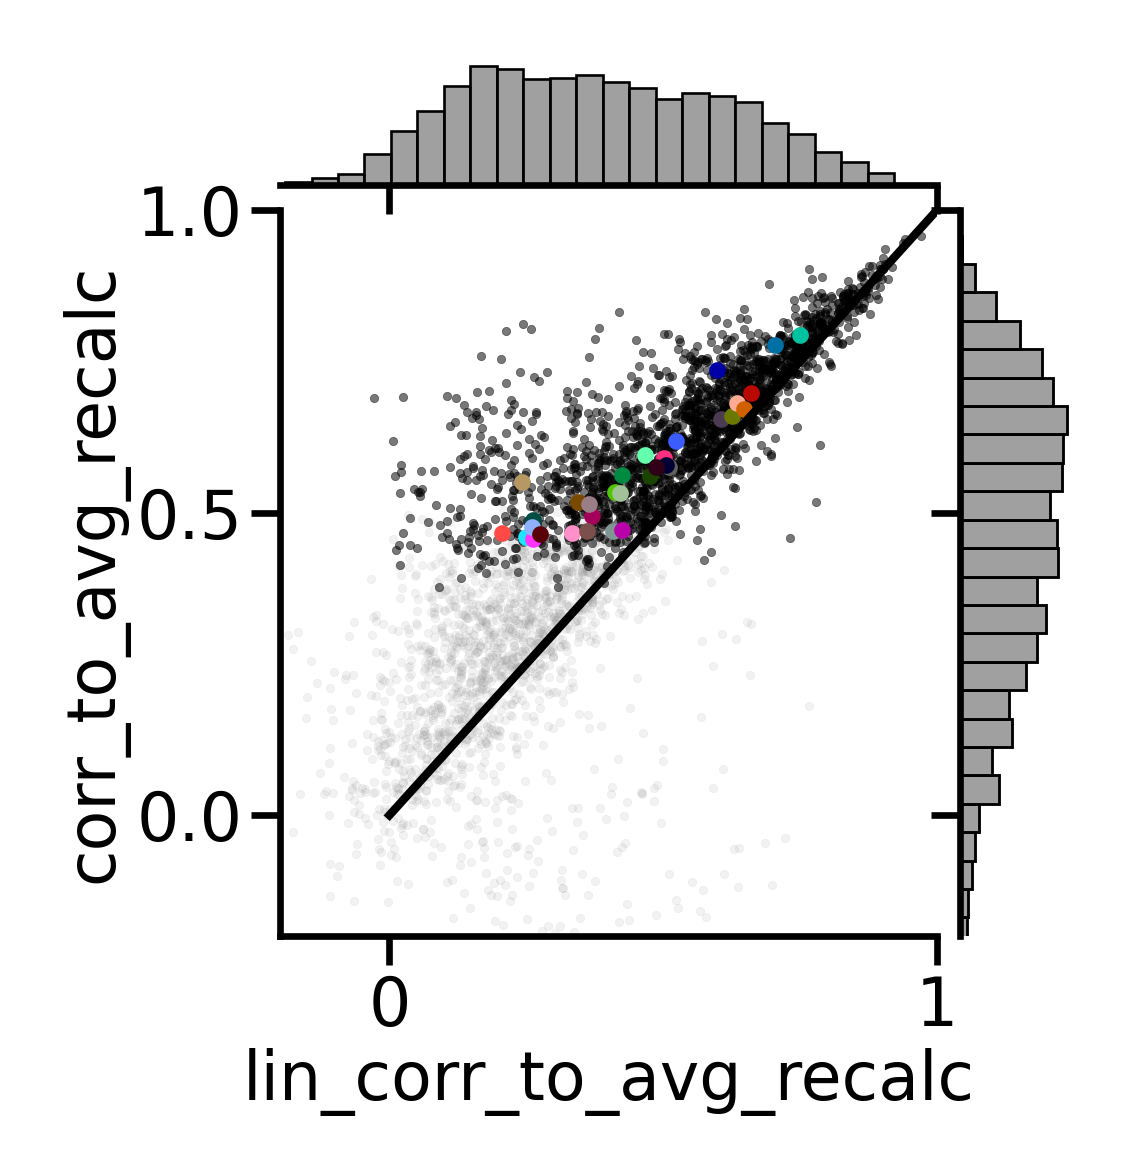

In [63]:
with mpl.rc_context(rc_dict):
    g = sns.jointplot(data=restr_df, x="lin_corr_to_avg_recalc", y="corr_to_avg_recalc",
                    color="grey", edgecolor=None,
                      height=rc_dict["figure.figsize"][0],
                       alpha=.1, xlim=[-.2, 1], ylim=[-.2, 1]
                     )
    sns.scatterplot(data=restr_df[restr_df["single_trial_corr_recalc"]>.3], 
                    x="lin_corr_to_avg_recalc", 
                    y="corr_to_avg_recalc",
                   color="k",edgecolor=None,
                      alpha=.5, ax=g.ax_joint
                    )
    g.ax_joint.plot([0,1], [0,1], color='k', linewidth=1)
    for t in range(1, 33):
        temp_df = restr_df[(restr_df['group_assignment']==t) & (restr_df["corr_to_avg_recalc"]>.3)]
        g.ax_joint.scatter(temp_df["lin_corr_to_avg_recalc"].mean(), 
                           temp_df["corr_to_avg_recalc"].mean(),
                           color=rgc_colors[t-1],#edgecolor="k"
                           )


# plot responses

In [64]:
[print(c) for c in df.columns];

dataset_hash
session_id
neuron_id
chirp_detrended_snippets
date
exp_num
experimenter
eye
field_id
scan_sequence_idx
chirp_detrended_snippets_times
chirp_detrended_traces
chirp_raw_traces
chirp_smoothed_snippets
chirp_smoothed_traces
chirp_traces_times
chirp_trigger_times
corr_to_avg
group_assignment
group_confidences
mb_detrended_snippets
mb_detrended_snippets_times
mb_detrended_traces
mb_raw_traces
mb_smoothed_snippets
mb_smoothed_traces
mb_traces_times
mb_trigger_times
model_readout_idx
movie_qis
natural_detrended_snippets
natural_detrended_snippets_times
natural_detrended_traces
natural_inferred_spikes
natural_raw_traces
natural_smoothed_snippets
natural_smoothed_traces
natural_traces_times
natural_trigger_times
roi_ids
single_trial_corr
test_prediction
test_response
natural_responses_final
responses_final
stim_id
corr_to_avg_recalc
single_trial_corr_recalc
test_prediction_recalc
lin_corr_to_avg_recalc
lin_single_trial_corr_recalc
lin_test_prediction_recalc
movie_qis_recalc
max_conf

In [65]:
#sample_types = [1, 5, 10, 18, 20, 21, 23, 24, 28, 31, 32]
#n_cells = len(sample_types)
#chirp_dur = 32
#mb_dur = 8
#movie_dur = 24
#total_dur_s = chirp_dur + mb_dur + movie_dur
#chirp_ratio = chirp_dur/total_dur_s
#mb_ratio = mb_dur/total_dur_s
#movie_ratio = movie_dur/total_dur_s
#
#chirp_key = 'chirp_detrended_snippets'
#mb_key = 'mb_detrended_snippets'
#movie_key = 'natural_inferred_spikes'
#with mpl.rc_context({'lines.linewidth': 1}):
#    
#    fig, axes = plt.subplots(n_cells, 
#                             3, 
#                             figsize=(3, 3), 
#                             gridspec_kw={
#                                 "width_ratios":[chirp_ratio, mb_ratio, movie_ratio],
#                                 "wspace": 0, 
#                                 "hspace":0
#                             })
#    for i, celltype in enumerate(sample_types):
#        chirp, bar, movie, ct = restr_df[[chirp_key,
#                                          mb_key, 
#                                          movie_key, 
#                                          "group_assignment"]].loc[example_nids[celltype]]
#        axes[i, 0].plot(chirp.mean(axis=1), color="k")
#        axes[i,1].plot(bar.mean(axis=1), color="k")
#        #axes[i,1].plot(bar_orig, color="r")
#        axes[i,2].plot(movie.mean(axis=1), color="k")
#        #axes[i,0].set_title("{}, {:.3f}, {}, {:.3f}".format(nid, test_corr.mean(), ct, movie_qi))
#    sns.despine()
#    for ax in fig.get_axes():
#        ax.axis("off")
#    plt.tight_layout()